# __*Use Darts to predict using past covariates data*__

## __*Install packages*__

In [1]:
!pip install -q torch
!pip install -q darts
!pip install -q torchmetrics


### __*Imports*__

In [2]:
from torchmetrics.regression import SymmetricMeanAbsolutePercentageError
import torch
import numpy as np
from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
    VARIMA,
)
from darts.metrics import mape, smape, mae
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset, ElectricityDataset

import logging

logging.disable(logging.CRITICAL)

import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

%matplotlib inline

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)


/home/javier/.pyenv/versions/3.10.6/envs/bakery/lib/python3.10/site-packages/statsforecast/core.py:25: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [4]:
!pip install yfinance


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 10.1 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 11.2 MB/s eta 0:00:0000:0100:01
  Created wheel for peewee: filename=peewee-3.17.0-cp310-cp310-linux_x86_64.whl size=845938 sha256=2d677070f553b3403913505b8765be4ae7b7e139dc368d4ac6deb8db799f4b40
  Stored in directory: /home/javier/.cache/pip/wheels/c7/70/ad/212867e96e7004265a69c4aa5dcff00a95f547a67ba26e7e76
Successfully built peewee


### __*Import some example data from yfinance*__

In [6]:
import yfinance as yf
import pandas as pd

# List of stock symbols
stocks = ['AAPL', 'GOOGL', 'MSFT', 'AMZN']

# Set the start and end dates
start_date = '2022-01-01'
end_date = '2023-01-01'

# Retrieve hourly data for each stock
dfs = []
for stock in stocks:
    # Download data
    stock_data = yf.download(stock, start=start_date, end=end_date, interval='1h')

    # Select only the 'Close' column
    stock_data = stock_data['Close']

    # Rename the column to the stock symbol
    stock_data = stock_data.rename(stock)

    # Add to the list of DataFrames
    dfs.append(stock_data)

# Concatenate DataFrames along the columns
df = pd.concat(dfs, axis=1)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [7]:
df


,AAPL,GOOGL,MSFT,AMZN
Datetime,,,,
2022-01-03 09:30:00-05:00,180.839996,144.700500,332.549988,168.761993
2022-01-03 10:30:00-05:00,181.749893,144.631012,331.989990,170.313858
2022-01-03 11:30:00-05:00,181.600006,144.787003,332.640015,170.071381
2022-01-03 12:30:00-05:00,182.229706,145.518005,332.320007,169.931244
2022-01-03 13:30:00-05:00,181.865005,144.955505,333.726593,170.438004
...,...,...,...,...
2022-12-30 11:30:00-05:00,128.815002,87.436699,239.050003,83.074997
2022-12-30 12:30:00-05:00,128.330002,87.000000,237.919998,82.745003
2022-12-30 13:30:00-05:00,128.220001,87.129997,237.559998,82.790001


In [8]:
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1753 entries, 2022-01-03 09:30:00-05:00 to 2022-12-30 15:30:00-05:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    1753 non-null   float64
 1   GOOGL   1753 non-null   float64
 2   MSFT    1753 non-null   float64
 3   AMZN    1753 non-null   float64
dtypes: float64(4)
memory usage: 68.5 KB


### __*Convert the pandas dataframe in a darts timeseries object (we need a datetime index!)*__

In [9]:
# Convert the DataFrame to a Darts TimeSeries
# Index must be datetimeindex
timeseries = TimeSeries.from_dataframe(df, freq='H')


### __*Scale the data using the Darts sklearn wrapper*__

In [7]:
from darts.dataprocessing.transformers.scaler import Scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
ts_transformer = Scaler(scaler)
target_transformer = Scaler(scaler)


In [9]:
scaled_ts = ts_transformer.fit_transform(timeseries)
target_transformer = target_transformer.fit(timeseries['AAPL'])


In [10]:
scaled_ts


<TimeSeries (DataArray) (Datetime: 8671, component: 4, sample: 1)>
array([[[0.97491097],
        [0.93221034],
        [0.9818257 ],
        [0.98108512]],

       [[0.9911013 ],
        [0.93115344],
        [0.97717842],
        [0.99859894]],

       [[0.98843427],
        [0.93352601],
        [0.98257281],
        [0.99586242]],

       ...,

       [[0.03861207],
        [0.05658   ],
        [0.19352693],
        [0.01083423]],

       [[0.05088969],
        [0.06238251],
        [0.19867212],
        [0.01263989]],

       [[0.06939491],
        [0.07346278],
        [0.21236514],
        [0.02448987]]])
Coordinates:
  * Datetime   (Datetime) datetime64[ns] 2022-01-03T09:30:00 ... 2022-12-30T1...
  * component  (component) object 'AAPL' 'GOOGL' 'MSFT' 'AMZN'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

### __*Handle missing values if you have*__
### __*(in this example, weekends are not available since we are dealing with stock markets)*__

In [11]:
from darts.utils.missing_values import fill_missing_values
scaled_ts = fill_missing_values(scaled_ts)
scaled_ts


<TimeSeries (DataArray) (Datetime: 8671, component: 4, sample: 1)>
array([[[0.97491097],
        [0.93221034],
        [0.9818257 ],
        [0.98108512]],

       [[0.9911013 ],
        [0.93115344],
        [0.97717842],
        [0.99859894]],

       [[0.98843427],
        [0.93352601],
        [0.98257281],
        [0.99586242]],

       ...,

       [[0.03861207],
        [0.05658   ],
        [0.19352693],
        [0.01083423]],

       [[0.05088969],
        [0.06238251],
        [0.19867212],
        [0.01263989]],

       [[0.06939491],
        [0.07346278],
        [0.21236514],
        [0.02448987]]])
Coordinates:
  * Datetime   (Datetime) datetime64[ns] 2022-01-03T09:30:00 ... 2022-12-30T1...
  * component  (component) object 'AAPL' 'GOOGL' 'MSFT' 'AMZN'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

### __*Train Test Split*__

<AxesSubplot:xlabel='Datetime'>

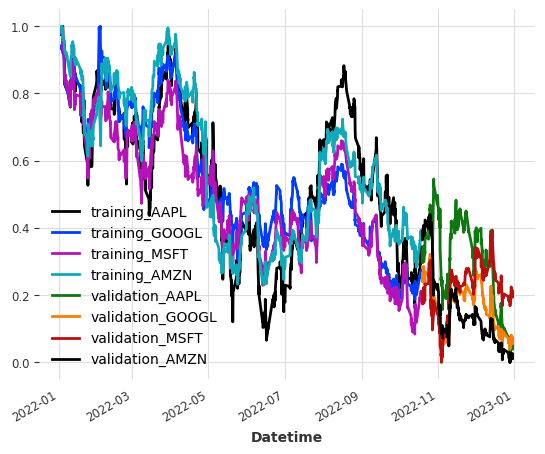

In [12]:
train, val = (scaled_ts).split_before(0.8)# (we standardize by dividing by 100 since Google Trends data tops out at 100 by default!)
train.plot(label="training")
val.plot(label="validation")


### __*Advanced multicovariate RNN training*__

### __*Setup Earlystopping and the train on GPU*__

In [13]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
# a period of 5 epochs (`patience`)
my_stopper = EarlyStopping(
    monitor="val_loss",
    patience=30,
    min_delta=0.005,
    mode='min',
)

pl_trainer_kwargs={"callbacks": [my_stopper],
                   "accelerator": "gpu",
                   "devices": [0]}


### __*Instanciate our model*__

In [14]:
# predict 15 days considering the latest 45 days

model_pastcov = BlockRNNModel(
    model="LSTM",
    input_chunk_length=45,
    output_chunk_length=15,
    dropout=0.2,
    torch_metrics=SymmetricMeanAbsolutePercentageError(),
    n_epochs=200,
    pl_trainer_kwargs = pl_trainer_kwargs,
    random_state=0,
)


In [15]:
train['AAPL']


<TimeSeries (DataArray) (Datetime: 6936, component: 1, sample: 1)>
array([[[0.97491097]],

       [[0.9911013 ]],

       [[0.98843427]],

       ...,

       [[0.33064051]],

       [[0.33163933]],

       [[0.33263815]]])
Coordinates:
  * Datetime   (Datetime) datetime64[ns] 2022-01-03T09:30:00 ... 2022-10-19T0...
  * component  (component) object 'AAPL'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

### __*Train the model*__

In [16]:
model_pastcov.fit(
    series=[train['AAPL']],    # the target training data
    past_covariates=train,     # the multi covariate features training data
    val_series=[val['AAPL']],  # the target validation data
    val_past_covariates=val,   # the multi covariate features validation data
    verbose=True,
)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

BlockRNNModel(model=LSTM, hidden_dim=25, n_rnn_layers=1, hidden_fc_sizes=None, dropout=0.2, input_chunk_length=45, output_chunk_length=15, torch_metrics=SymmetricMeanAbsolutePercentageError(), n_epochs=200, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f81aa597790>], 'accelerator': 'gpu', 'devices': [0]}, random_state=0)

### __*Do a prediction*__

Predicting: 0it [00:00, ?it/s]

<AxesSubplot:xlabel='Datetime'>

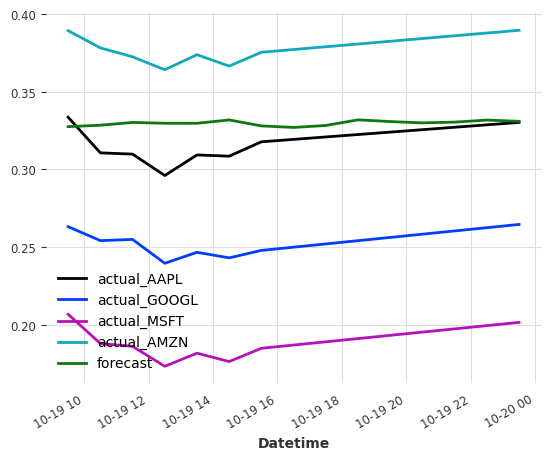

In [18]:
pred_cov = model_pastcov.predict(n=15,                        # n of days to predict
                                 series=train['AAPL'][-45:],  # target input for prediction
                                 past_covariates=train[-45:]) # past-covariates input for prediction

val[:15].plot(label="actual")
pred_cov.plot(label="forecast")


### __*Check the metrics*__

In [19]:
# check the SMAPE error

smape(val['AAPL'][:15], pred_cov)


3.6320905494796163

### __*Extract the predictions as np array in the original scale*__

In [21]:
target_transformer.inverse_transform(pred_cov).values()


array([[144.45919538],
       [144.51003158],
       [144.61066389],
       [144.58153947],
       [144.58048143],
       [144.70175457],
       [144.48565294],
       [144.43052935],
       [144.50120746],
       [144.70445222],
       [144.64298992],
       [144.59493626],
       [144.6228614 ],
       [144.6969396 ],
       [144.65217191]])